In [1]:
#https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.129.020502

import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
from IPython.display import clear_output
import math

num_q = 8
J = 1
Delta = 1.5
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H1 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

List_2 = []
op = ""
for i in range(num_q):
    op = ""
    for k in range(i):
        op += "I"
    op += "X"
    for k in range(i+1,num_q):
        op += "I"
    List_2.append(op)
H2 = SparsePauliOp(List_2, Delta*np.ones(num_q))

H = SparsePauliOp.sum([H1,H2])

# Ordering in SparsePauliOp e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
Hmat = Hmat.data

e, v = LA.eig(Hmat)
min_index = np.argmin(e)
v_min = v[:,min_index]
ground_e = np.min(e)
print(H[-1])
print(np.min(e))
print(H.size)
print(H.paulis[0])



SparsePauliOp(['IIIIIIIX'],
              coeffs=[1.5+0.j])
(-13.191404952188934+0j)
15
IIIIIIZZ


In [2]:


"""circuit construction"""

layer = 10
num_p = 2*layer*num_q

weights = ParameterVector("weight",num_p)


def circuit_ex(weights):
    circ = QuantumCircuit(num_q, num_q)
    
    for j in range(num_q):
        circ.h(j)
    
    for i in range(layer):
        for j in range(num_q):
            circ.ry(weights[2*i*num_q+j],j)
        for j in range(num_q):
            circ.rz(weights[2*i*num_q+num_q+j],j)
        for j in range(int(num_q/2)):
            circ.cx(2*j,2*j+1)
        for j in range(int(num_q/2)-1):
            circ.cx(2*j+1,2*j+2)
        
        
    return circ


In [3]:

simulator = AerSimulator()

def estimate_loss(WEIGHTS, SHOTS):
    estimate = 0
    qc = circuit_ex(WEIGHTS)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc) ## output distribution of 0 and 1
    for i in range(SHOTS):
        for j in range(num_q-1):
            if c[i][num_q-1-j] == c[i][num_q-1-(j+1)]:
                estimate += 1
            else:
                estimate += -1
    estimate = J*estimate/SHOTS
    
    estimate_1 = 0
    qc = circuit_ex(WEIGHTS)
    for i in range(num_q):
        qc.h(i)
    qc = transpile(qc, simulator)
    ind = list(range(num_q))
    rind = ind
    rind.reverse()
    qc.measure(ind, rind)
    result = simulator.run(qc, shots = SHOTS, memory=True).result()
    c = result.get_memory(qc)
    for i in range(SHOTS):
        for j in range(num_q):
            if c[i][num_q-1-j] == '0':
                estimate_1 += 1
            else:
                estimate_1 += -1
    estimate_1 = Delta*estimate_1/SHOTS
    return estimate+estimate_1

def expectation_loss(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    Hpsi = Hmat.dot(psi)
    expectation = np.inner(np.conjugate(psi),Hpsi)
    return np.real(expectation)


def BCD_estimate(WEIGHTS, INDEX, SHOTS):
    direction_index = -WEIGHTS[INDEX] *identity[:,INDEX] 
    f_zero = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi/2) *identity[:,INDEX]
    f_half_pi = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi) *identity[:,INDEX]
    f_pi = estimate_loss((WEIGHTS + direction_index.flatten()), SHOTS)
    
    a = 0.5*(f_zero + f_pi)
    b = 0.5*(f_zero - f_pi)
    c = f_half_pi - a
    
    value = np.arctan2(b,c)
    return -np.pi/2 - value 

def BCD_exact(WEIGHTS, INDEX):
    direction_index = -WEIGHTS[INDEX] *identity[:,INDEX]
    f_zero = expectation_loss((WEIGHTS + direction_index.flatten()))  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi/2) *identity[:,INDEX]
    f_half_pi = expectation_loss((WEIGHTS + direction_index.flatten()))  
 
    direction_index = (-WEIGHTS[INDEX]+np.pi) *identity[:,INDEX]
    f_pi = expectation_loss((WEIGHTS + direction_index.flatten()))
    
    a = 0.5*(f_zero + f_pi)
    b = 0.5*(f_zero - f_pi)
    c = f_half_pi - a
    
    value = np.arctan2(b,c)
    return -np.pi/2 - value 

def parameter_shift(WEIGHTS, INDEX, SHOTS):
    identity = np.identity(num_p)
    direction_index = np.pi/2 *identity[:,INDEX] ## parameter shift rule with eigenvalues +-0.5
    g_p = estimate_loss((WEIGHTS+direction_index.flatten()), SHOTS)  
    g_m = estimate_loss((WEIGHTS-direction_index.flatten()), SHOTS)
    g = 0.5*(g_p-g_m) ## parameter shift rule with eigenvalues +-0.5
    return g

def fidelity(WEIGHTS):
    qc = circuit_ex(WEIGHTS)
    qc.save_statevector()
    qc = transpile(qc, simulator)
    result = simulator.run(qc).result()
    state_vector = result.get_statevector(qc)
    psi = np.asarray(state_vector)
    return np.absolute(np.vdot(psi,v_min))**2

Loss and Fidelity: -12.379089837763516 0.876612202452891


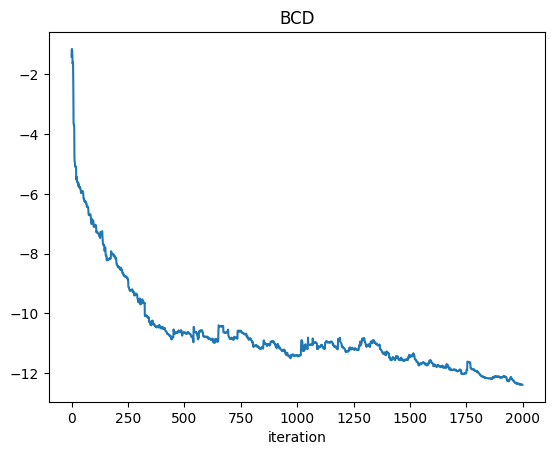

In [4]:
"""optimization phase"""



"""initialization of weights"""
mat = scipy.io.loadmat('w0')
w0 = mat['w0']

initial_weights = np.zeros(num_p) #np.ones(num_p)
initial_weights[:10] = w0.flatten()



T = 2000
n_shot = 1000


identity = np.identity(num_p)
num_results = 1
cost_mat = np.empty((0,T), int)
fidelity_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
F = 0
loss = 0 

for k in range(num_results):
    cost = []
    cost_f = []
    Weights = []
    weights = initial_weights
    iteration = 0
    while iteration < T:
        iteration = iteration + 1
        index = np.random.randint(0,num_p,1)
        weights[index] = BCD_estimate(weights, index, n_shot)
        Weights.append(weights)
        
        loss = expectation_loss(weights)
        F = fidelity(weights)
        clear_output(wait=True)
        print('Loss and Fidelity:',loss, F)
        plt.plot(cost)
        plt.xlabel('iteration')
        plt.title('BCD')
        plt.show()
        cost.append(loss.flatten())
        cost_f.append(F.flatten()) 
    Cost = np.asarray(cost)
    WEIGHTS = np.asarray(Weights)
    FIDELITY = np.asarray(cost_f)
    cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
    weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
    fidelity_mat = np.append(fidelity_mat, np.transpose(FIDELITY), axis = 0)
    
    
scipy.io.savemat('bcdm_loss_1.mat', {'bcdm_loss_1': cost_mat})
scipy.io.savemat('bcdm_weight_1.mat', {'bcdm_weight_1': weight_mat})
scipy.io.savemat('bcdm_fidelity_1.mat', {'bcdm_fidelity_1': fidelity_mat})
